In [1]:
import warnings
warnings.simplefilter("ignore")
import pypsa
import time
import logging
import numpy as np
import os 
import sys
import yaml
import pyomo.environ as pyomo_env
import pandas as pd
from scipy.spatial import ConvexHull,  Delaunay
from scipy.interpolate import griddata
from multiprocessing import Lock, Process, Queue, current_process
import queue # imported for using queue.Empty exception
sys.path.append(os.getcwd())
import plotly.graph_objects as go
import plotly.figure_factory as ff
warnings.simplefilter("ignore")

In [2]:

network = pypsa.Network()
network.import_from_hdf5('PyPSA_project/data/networks/euro_00')
dim = 2

bus_list = ['DK','SE','NO','DE','PL','CZ','NL','AT','CH']

bus_list = bus_list[:dim]

for bus in network.buses.index:
    if bus not in bus_list:
        network.remove('Bus',name=bus)
        network.remove('Load',bus)

for link in network.links.index:
    if not (network.links.loc[link].bus0 in bus_list and network.links.loc[link].bus1 in bus_list ):
        network.remove('Link',link)

for generator in network.generators.index:
    if not network.generators.loc[generator].bus in bus_list:
        network.remove('Generator',generator)
        
for generator in network.generators.index:
    if network.generators.loc[generator].type == 'solar':
        network.remove('Generator',generator)

network.snapshots = network.snapshots[0:10]

INFO:pypsa.io:Imported network euro_00 has buses, carriers, generators, global_constraints, links, loads


In [3]:
network.remove('Generator','DK onwind')
network.remove('Generator','DK ocgt')
network.remove('Generator','SE offwind')

In [4]:
network.generators

,bus,control,type,p_nom_extendable,p_nom_max,carrier,marginal_cost,capital_cost,efficiency,min_up_time,...,p_set,q_set,sign,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
name,,,,,,,,,,,,,,,,,,,,,
DK offwind,DK,PQ,wind,True,1.013904e+05,offwind,0.020000,295041.156155,1.00,0,...,0.0,0.0,1.0,False,0.0,0.0,NaN,NaN,1.0,1.0
SE onwind,SE,Slack,wind,True,3.024149e+05,onwind,0.015000,136428.031355,1.00,0,...,0.0,0.0,1.0,False,0.0,0.0,NaN,NaN,1.0,1.0
SE ocgt,SE,PQ,ocgt,True,inf,ocgt,58.384615,47234.561404,0.39,0,...,0.0,0.0,1.0,False,0.0,0.0,NaN,NaN,1.0,1.0


### Initial solution

In [5]:

network.lopf(network.snapshots, 
            solver_name='gurobi'),

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 1229357275.695268
  Upper bound: 1229357275.695268
  Number of objectives: 1
  Number of constraints: 122
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 211
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

(('ok', 'optimal'),)

(<matplotlib.collections.PathCollection at 0x1cd0a452358>,
 <matplotlib.collections.LineCollection at 0x1cd0a452cf8>)

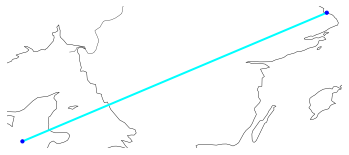

In [6]:
network.plot()

In [7]:
co2_emission = [constraint.body() for constraint in network.model.global_constraints.values()][0]
co2_emission
network.remove('GlobalConstraint',"co2_limit")
target = (1-0.60)*co2_emission
network.add("GlobalConstraint","co2_limit",
      sense="<=",
      carrier_attribute="co2_emissions",
      constant=target)


In [8]:
network.lopf(network.snapshots, 
            solver_name='gurobi')
old_objective_value = network.model.objective()

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 3343442756.6917167
  Upper bound: 3343442756.6917167
  Number of objectives: 1
  Number of constraints: 122
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 211
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

In [9]:
network.generators.p_nom_opt
inital_solution = []
"""
for var_type in ['ocgt','wind','solar']:
    filter1 = network.generators.type==var_type
    inital_solution.append(sum(network.generators.p_nom_opt[filter1]))
    """
inital_solution = network.generators.p_nom_opt
inital_solution

name
DK offwind        0.000000
SE onwind     19242.427111
SE ocgt       10578.323117
Name: p_nom_opt, dtype: float64

### Function definitions

In [10]:
def direction_search(network, snapshots,options,direction): #  MGA_slack = 0.05, point=[0,0,0],dim=3,old_objective_value=0):
# Identify the nonzero decision variables that should enter the MGA objective function.
    old_objective_value = options['old_objective_value']
    dim = options['dim']
    MGA_slack = 0.1

    if dim == 3:
        generators = [gen_p for gen_p in network.model.generator_p_nom]
        types = ['ocgt','wind','olar']
        variables = []
        for i in range(3):
            gen_p_type = [gen_p  for gen_p in generators if gen_p[-4:]==types[i]]
            variables.append(sum([network.model.generator_p_nom[gen_p] for gen_p in gen_p_type]))
            
                             
    elif dim == 2:
        generators = [gen_p for gen_p in network.model.generator_p_nom]
        types = ['ocgt','wind','olar']
        variables = []
        for i in range(3):
            gen_p_type = [gen_p  for gen_p in generators if gen_p[-4:]==types[i]]
            variables.append(sum([network.model.generator_p_nom[gen_p] for gen_p in gen_p_type]))
        slack = 0    
        point = options['point']
        #point = inital_solution
        network.model.ocgt_constraint_u = pyomo_env.Constraint(expr=variables[0]== point[0])
        #network.model.ocgt_constraint_l = pyomo_env.Constraint(expr=variables[0]>= inital_solution[0]+1000-slack)
        network.model.wind_constraint_u = pyomo_env.Constraint(expr=variables[1]== point[1])
        #network.model.wind_constraint_l = pyomo_env.Constraint(expr=variables[1]>= inital_solution[1]+1000-slack)
        #network.model.solar_constraint_u = pyomo_env.Constraint(expr=variables[2]== point[2])
        #network.model.solar_constraint_l = pyomo_env.Constraint(expr=variables[2]>= inital_solution[2]+1000-slack)
        """                                                     
        variables = []
        for bus in network.buses.index:
            var = []
            for generator in network.model.generator_p_nom:
                if network.generators.loc[generator].type == 'wind' and network.generators.loc[generator].bus == bus :
                    var.append(network.model.generator_p_nom[generator])
            variables.append(sum(var))
            print(sum(var))    """       
        variables = [network.model.generator_p_nom[gen_p] for gen_p in network.model.generator_p_nom]
                             
    else :
        variables = [network.model.generator_p_nom[gen_p] for gen_p in network.model.generator_p_nom]
        
    objective = 0
    for i in range(len(variables)):
        #print(variables[i])
        objective += direction[i]*variables[i]

    print(objective)
    # Add the new MGA objective function to the model.
    #objective += network.model.objective.expr * 1e-9
    network.model.mga_objective = pyomo_env.Objective(expr=objective)
    # Deactivate the old objective function and activate the MGA objective function.
    network.model.objective.deactivate()
    network.model.mga_objective.activate()
    # Add the MGA slack constraint.
    network.model.mga_constraint = pyomo_env.Constraint(expr=network.model.objective.expr <= 
                                          (1 + MGA_slack) * old_objective_value)


In [11]:
def rand_split(n):
    
    rand_list = np.random.random(n-1)
    rand_list.sort()
    rand_list = np.concatenate([[0],rand_list,[1]])
    rand_list = np.diff(rand_list)

    return rand_list

def create_interior_points(hull,m):
    #m = 20

    # Generate Delunay triangulation of hull
    try :
        tri = Delaunay(hull.points[hull.vertices])#,qhull_options='Qs')#,qhull_options='A-0.999')
    except : 
        points = np.append(hull.points[hull.vertices],[np.mean(hull.points,axis=0)],axis=0)            
        tri = Delaunay(points,qhull_options='Qs')
    # Distribute number of points based on simplex size 
    tri.volumes = []
    for i in range(len(tri.simplices)):
        try :
            tri.volumes.append(ConvexHull(tri.points[tri.simplices[i,:]]).volume)
        except : 
            tri.volumes.append(0)
    tri.volumes = np.array(tri.volumes)
    tri.volumes_norm = tri.volumes/sum(tri.volumes)

    tri.n_points_in_tri =  (tri.volumes_norm*m).astype(int)
    # Generate interrior points of each simplex
    interrior_points = []
    for i in range(len(tri.simplices)):
        tri_face = tri.points[tri.simplices[i,:]]
        for j in range(tri.n_points_in_tri[i]):
            dim = len(tri.points[0,:])
            rand_list = rand_split(dim+1)

            new_point = sum([face*rand_n for face,rand_n in zip(tri_face,rand_list)])
            interrior_points.append(new_point)
    interrior_points = np.array(interrior_points)
    return interrior_points

### MGA with $\sum$ variables

In [12]:
#logging.disable()
data_detail_sum = []
options = dict(dim=3,old_objective_value=old_objective_value)
dim=3
old_volume = 0
epsilon = 1
while epsilon > 0.05:
    data_detail = list(data_detail_sum)
    if len(data_detail_sum)<=1 : # if only original solution exists, max/min directions are chosen
        directions = np.concatenate([np.diag(np.ones(dim)),-np.diag(np.ones(dim))],axis=0)
    else : # Otherwise search in directions normal to faces
        directions = np.array(hull.equations)[:,0:-1]
    # Itterate over directions in batch 
    for direction in directions:
        print(direction)
        direction = np.concatenate([direction,[0]])
        network.lopf(network.snapshots,                                 
                        solver_name='gurobi',                                 
                        extra_functionality=lambda network,                                 
                        snapshots: direction_search(network,snapshots,options,direction))

        var = []
        for var_type in ['ocgt','wind']:#,'solar']:
            filter1 = network.generators.type==var_type
            var.append(sum(network.generators.p_nom_opt[filter1]))
        data_detail_sum.append(var)
    

    hull = ConvexHull(data_detail_sum)#,qhull_options='QJ')
    
    delta_v = hull.volume - old_volume
    old_volume = hull.volume
    epsilon = delta_v/hull.volume
    
    print(epsilon)


data_detail_sum = np.array(data_detail_sum)

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


[1. 0. 0.]
generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 8813.823433659387
  Upper bound: 8813.823433659387
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 16222.500008262716
  Upper bound: 16222.500008262716
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.opf:Solving model using gurobi


0.0
    solver failure.


INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject

INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -17656.705253285883
  Upper bound: -17656.705253285883
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Solving model using gurobi


- (generator_p_nom[DK offwind] + generator_p_nom[SE onwind])


INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -22278.50941233782
  Upper bound: -22278.50941233782
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.opf:Solving model using gurobi


0.0
    solver failure.


INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject

INFO:pypsa.opf:Solving model using gurobi


-0.9522170422862258*generator_p_nom[SE ocgt] - 0.30542217401438304*(generator_p_nom[DK offwind] + generator_p_nom[SE onwind])


INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -22690.079574295363
  Upper bound: -22690.079574295363
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Solving model using gurobi


0.35934977585145833*generator_p_nom[SE ocgt] - 0.933202946092385*(generator_p_nom[DK offwind] + generator_p_nom[SE onwind])


INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -17588.053218251986
  Upper bound: -17588.053218251986
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Solving model using gurobi


-0.9994483758897504*generator_p_nom[SE ocgt] + 0.03321059968353799*(generator_p_nom[DK offwind] + generator_p_nom[SE onwind])


INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -17007.912845244384
  Upper bound: -17007.912845244384
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.opf:Solving model using gurobi


0.3279659486562107*generator_p_nom[SE ocgt] + 0.9446895450474889*(generator_p_nom[DK offwind] + generator_p_nom[SE onwind])


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 18543.947407932774
  Upper bound: 18543.947407932774
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

In [13]:
hull_sum = ConvexHull(data_detail_sum)
interior_points_sum = create_interior_points(hull_sum,5000)

In [29]:
fig = go.Figure()



fig.add_trace(go.Scatter(x=hull_sum.points[np.append(hull_sum.vertices,hull_sum.vertices[0])][:,1],
                          y=hull_sum.points[np.append(hull_sum.vertices,hull_sum.vertices[0])][:,0],
                          #z=data_detail_sum[:,2],
                          mode='lines'))

fig.add_trace(go.Scatter(x=data_detail_sum[:,1],
                          y=data_detail_sum[:,0],
                          #z=data_detail_sum[:,2],
                          mode='markers',name='MGA solutions'))

fig.add_trace(go.Scatter(y=[inital_solution[2]],
                          x=[inital_solution[0]+inital_solution[1]],
                          #z=[np.mean(data_detail_sum,axis=0)[2]],
                          mode='markers',name='Initial_solution'))

fig.add_trace(go.Scatter(x=interior_points_sum[:,1],
                          y=interior_points_sum[:,0],
                          #z=[np.mean(data_detail_sum,axis=0)[2]],
                          mode='markers',name='Interrior_points'))
fig.update_yaxes(title_text='$\Large x_3$')
fig.update_xaxes(title_text='$\Large x_1+x_2$',title_font=dict(size=50))

fig.update_layout(
    autosize=False,
    width=700,
    height=500,
    showlegend=False,
    font_size=18,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black',)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black',)

fig.write_image("C:/Users\Tim\OneDrive - Aarhus universitet\Speciale\Report\Images\multi_1.pdf")
fig.show()

In [88]:
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
matplotlib.rcParams.update({'font.size': 18})
def plot_hist(ax,x,w=[] ,color='C1'):
    if len(w)<=0 :
        w = np.ones(len(x))
    kde1 = stats.gaussian_kde(x*1e-3,weights=w)
    xx = np.linspace(7, 23, 1000)
    ax.hist(x=x*1e-3,stacked=False,weights=w,bins=20,density=True,histtype='stepfilled', alpha=0.5,color=color);
    ax.plot(xx, kde1(xx),color=color)
    return ax

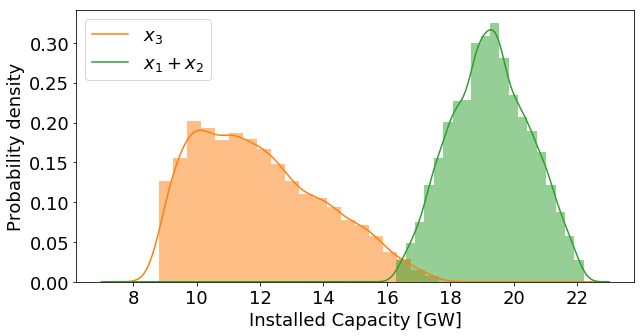

In [98]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_hist(ax,interior_points_sum[:,0],color='C1')
ax = plot_hist(ax,interior_points_sum[:,1],color='C2')
ax.legend(['$x_3$','$x_1+x_2$']);
ax.set_xlabel('Installed Capacity [GW]')
ax.set_ylabel('Probability density')
fig.savefig("C:/Users\Tim\OneDrive - Aarhus universitet\Speciale\Report\Images\multi_2.pdf", bbox_inches='tight')

### Multiplicity MGA

In [80]:
sample_points = create_interior_points(hull_sum,50)
sample_points = np.concatenate([data_detail_sum,sample_points])

In [81]:
weights = []
for point in sample_points : 
    data_detail = []
    dim = 3
    old_volume = 0
    epsilon = 1
    while epsilon > 0.05:
        if len(data_detail)<=1 : # if only original solution exists, max/min directions are chosen
            test = np.array([[1,-1,0]])
            directions = np.concatenate([test,-test],axis=0)
        else : # Otherwise search in directions normal to faces
            directions = np.array(hull.equations)[:,0:-1]
        # Itterate over directions in batch 
        for direction in directions:
            #print(direction)
            network = network.copy()
            #options = dict(dim=2,old_objective_value=old_objective_value,point=data_detail_sum[1,:])
            options = dict(dim=2,old_objective_value=old_objective_value,point=point)
            network.lopf(network.snapshots,                                 
                            solver_name='gurobi',                                 
                            extra_functionality=lambda network,                                 
                            snapshots: direction_search(network,snapshots,options,direction),
                            solver_options=dict(threads=4,method=2))

            var = []
            for country in bus_list:
                filter1 = network.generators.bus==country
                filter2 = network.generators.type=='wind'
                filter = [a and b for a,b in zip(filter1,filter2)]
                var.append(sum(network.generators.p_nom_opt[filter]))
            data_detail.append(network.generators.p_nom_opt.values)
        #hull = ConvexHull(data_detail)#,qhull_options='QJ')

        #delta_v = hull.volume - old_volume
        #old_volume = hull.volume
        #epsilon = delta_v/hull.volume
        epsilon = 0
        print(epsilon)
        break


    data_detail = np.array(data_detail)

    direction = directions[0]
    vector = data_detail[0]-data_detail[1]
    len1 = abs(np.dot(vector, direction) / np.linalg.norm(direction))

    weight = len1
    weights.append(weight)

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -11583.260517810148
  Upper bound: -11583.260517810148
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 11583.260517810148
  Upper bound: 11583.260517810148
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -5234.562453386061
  Upper bound: -5234.562453386061
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 5234.562453386039
  Upper bound: 5234.562453386039
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19242.427110793364
  Upper bound: -19242.427110793364
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 19242.427110793356
  Upper bound: 19242.427110793356
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19242.427110793364
  Upper bound: -19242.427110793364
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 19242.427110793356
  Upper bound: 19242.427110793356
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -22278.50941233782
  Upper bound: -22278.50941233782
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 22278.509412337826
  Upper bound: 22278.509412337826
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19242.427110793364
  Upper bound: -19242.427110793364
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 19242.427110793356
  Upper bound: 19242.427110793356
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19242.427110793364
  Upper bound: -19242.427110793364
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 19242.427110793356
  Upper bound: 19242.427110793356
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -22278.50941233781
  Upper bound: -22278.50941233781
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 22278.509412337797
  Upper bound: 22278.509412337797
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19242.427110793364
  Upper bound: -19242.427110793364
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 19242.427110793356
  Upper bound: 19242.427110793356
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -5234.562453386061
  Upper bound: -5234.562453386061
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 5234.562453386039
  Upper bound: 5234.562453386039
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -16055.290237059056
  Upper bound: -16055.290237059056
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 12802.84070948034
  Upper bound: 12802.84070948034
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -15858.944265323902
  Upper bound: -15858.944265323902
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 10936.245046254186
  Upper bound: 10936.245046254186
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -12799.107395383355
  Upper bound: -12799.107395383355
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 9800.027043647875
  Upper bound: 9800.027043647875
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -13135.768942350634
  Upper bound: -13135.768942350634
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 9359.497536901035
  Upper bound: 9359.497536901035
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -12429.865005743952
  Upper bound: -12429.865005743952
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 8688.54850074476
  Upper bound: 8688.54850074476
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was sol

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -8699.531792022128
  Upper bound: -8699.531792022128
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 8524.44795710178
  Upper bound: 8524.44795710178
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was sol

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -17312.600450030906
  Upper bound: -17312.600450030906
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 13420.482183022621
  Upper bound: 13420.482183022621
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -10887.703965565532
  Upper bound: -10887.703965565532
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 8809.893222789113
  Upper bound: 8809.893222789113
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -18750.28338377551
  Upper bound: -18750.28338377551
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 15999.39386907899
  Upper bound: 15999.39386907899
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -18211.3591108083
  Upper bound: -18211.3591108083
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 13458.304251683985
  Upper bound: 13458.304251683985
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -11315.882291524005
  Upper bound: -11315.882291524005
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 10645.728736505866
  Upper bound: 10645.728736505866
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -15317.736609056043
  Upper bound: -15317.736609056043
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 10247.360131534439
  Upper bound: 10247.360131534439
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -9948.336200694986
  Upper bound: -9948.336200694986
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 8194.682313774825
  Upper bound: 8194.682313774825
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -14204.25471667627
  Upper bound: -14204.25471667627
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 10635.686527302802
  Upper bound: 10635.686527302802
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -9925.351415622397
  Upper bound: -9925.351415622397
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 9052.835398810144
  Upper bound: 9052.835398810144
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -15186.740234998768
  Upper bound: -15186.740234998768
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 10578.541629274878
  Upper bound: 10578.541629274878
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -9498.899373396118
  Upper bound: -9498.899373396118
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 7756.11743260454
  Upper bound: 7756.11743260454
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was sol

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -17696.90485714327
  Upper bound: -17696.90485714327
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 14389.141748645718
  Upper bound: 14389.141748645718
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -18869.997868645267
  Upper bound: -18869.997868645267
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 17468.438294807856
  Upper bound: 17468.438294807856
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19265.701808734622
  Upper bound: -19265.701808734622
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 13438.424200808047
  Upper bound: 13438.424200808047
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -12737.073974344246
  Upper bound: -12737.073974344246
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 10052.118276641824
  Upper bound: 10052.118276641824
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -18256.349849881495
  Upper bound: -18256.349849881495
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 14412.868413257318
  Upper bound: 14412.868413257318
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -12640.9881932352
  Upper bound: -12640.9881932352
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 8682.419160850124
  Upper bound: 8682.419160850124
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -18618.53246162738
  Upper bound: -18618.53246162738
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 14385.371232008047
  Upper bound: 14385.371232008047
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -14505.292034255996
  Upper bound: -14505.292034255996
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 11010.876678976612
  Upper bound: 11010.876678976612
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -16771.146700309844
  Upper bound: -16771.146700309844
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 16133.333823834313
  Upper bound: 16133.333823834313
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -20582.273528922524
  Upper bound: -20582.273528922524
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 19165.815835475252
  Upper bound: 19165.815835475252
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -21359.937011425955
  Upper bound: -21359.937011425955
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 20766.69342942732
  Upper bound: 20766.69342942732
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19760.63997755725
  Upper bound: -19760.63997755725
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 17432.550292020693
  Upper bound: 17432.550292020693
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -20660.418627430903
  Upper bound: -20660.418627430903
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 18805.113818889236
  Upper bound: 18805.113818889236
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19864.917202021985
  Upper bound: -19864.917202021985
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 15275.679165960275
  Upper bound: 15275.679165960275
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -20107.656174418407
  Upper bound: -20107.656174418407
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 18064.771939670216
  Upper bound: 18064.771939670216
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19324.791697414825
  Upper bound: -19324.791697414825
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 17746.108265261908
  Upper bound: 17746.108265261908
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -16917.62243906728
  Upper bound: -16917.62243906728
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 13041.769753782504
  Upper bound: 13041.769753782504
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -20541.431042473007
  Upper bound: -20541.431042473007
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 19389.165552559884
  Upper bound: 19389.165552559884
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19702.824457219496
  Upper bound: -19702.824457219496
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 15241.27704237857
  Upper bound: 15241.27704237857
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19548.503284444763
  Upper bound: -19548.503284444763
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 14016.830434529185
  Upper bound: 14016.830434529185
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -18473.53712871672
  Upper bound: -18473.53712871672
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 15322.193357183964
  Upper bound: 15322.193357183964
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -20609.993033258455
  Upper bound: -20609.993033258455
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 20569.50273122827
  Upper bound: 20569.50273122827
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -20055.609824392748
  Upper bound: -20055.609824392748
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 19306.829424009135
  Upper bound: 19306.829424009135
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19877.398157278603
  Upper bound: -19877.398157278603
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 18599.72899541882
  Upper bound: 18599.72899541882
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -20113.7655107853
  Upper bound: -20113.7655107853
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 16120.662971898671
  Upper bound: 16120.662971898671
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -20412.283882398297
  Upper bound: -20412.283882398297
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 19408.236570975583
  Upper bound: 19408.236570975583
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19887.16165969771
  Upper bound: -19887.16165969771
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 16515.430395833253
  Upper bound: 16515.430395833253
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -20804.903520686785
  Upper bound: -20804.903520686785
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 18926.952881584933
  Upper bound: 18926.952881584933
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -21402.78762459136
  Upper bound: -21402.78762459136
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 19776.791256704822
  Upper bound: 19776.791256704822
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19719.744311514878
  Upper bound: -19719.744311514878
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 16864.418608216103
  Upper bound: 16864.418608216103
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -20589.44167392679
  Upper bound: -20589.44167392679
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 17195.208206033698
  Upper bound: 17195.208206033698
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind] - generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -19861.878374072705
  Upper bound: -19861.878374072705
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind] + generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 18914.643459991716
  Upper bound: 18914.643459991716
  Number of objectives: 1
  Number of constraints: 125
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 248
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

In [100]:
diff = np.max(data_detail,axis=0)-np.min(data_detail,axis=0)
diff


array([1839.47747559, 1839.47747559,    0.        ])

In [82]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=hull_sum.points[np.append(hull_sum.vertices,hull_sum.vertices[0])][:,1],
                          y=hull_sum.points[np.append(hull_sum.vertices,hull_sum.vertices[0])][:,0],
                          #z=data_detail_sum[:,2],
                          mode='lines'))

fig.add_trace(go.Scatter(x=sample_points[:,1],
                          y=sample_points[:,0],
                          #z=[inital_solution[2]+500],
                          mode='markers',
                            marker=dict(color=weights,size=10,colorbar={'thickness':20,'title':'Scenario cost'})))
fig.update_yaxes(title_text='$x_3$')
fig.update_xaxes(title_text='$x_1+x_2$')

In [83]:
interior_weights = griddata(sample_points, 
                                    weights, 
                                    interior_points_sum,
                                    method='linear')


In [85]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=hull_sum.points[np.append(hull_sum.vertices,hull_sum.vertices[0])][:,1],
                          y=hull_sum.points[np.append(hull_sum.vertices,hull_sum.vertices[0])][:,0],
                          #z=data_detail_sum[:,2],
                          mode='lines'))
fig.add_trace(go.Scatter(x=interior_points_sum[:,1],
                          y=interior_points_sum[:,0],
                          #z=[inital_solution[2]+500],
                          mode='markers',
                            marker=dict(color=interior_weights,size=10,colorbar={'thickness':20,'title':'Weight'})))
fig.update_yaxes(title_text='$\Large x_3$')
fig.update_xaxes(title_text='$\Large x_1+x_2$')

fig.update_layout(
    autosize=False,
    width=700,
    height=500,
    showlegend=False,
    font_size=18,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black',)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black',)

fig.write_image("C:/Users\Tim\OneDrive - Aarhus universitet\Speciale\Report\Images\multi_4.pdf")
fig.show()

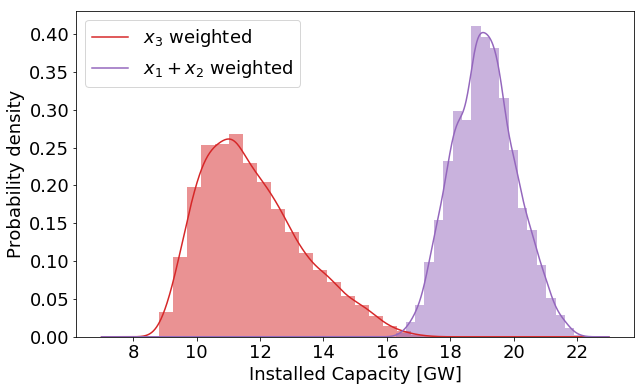

In [89]:
fig, ax = plt.subplots(figsize=(10,6))
#ax = plot_hist(ax,interior_points_sum[:,0],color='C1')
#ax = plot_hist(ax,interior_points_sum[:,1],color='C2')
ax = plot_hist(ax,interior_points_sum[:,0],color='C3',w=interior_weights)
ax = plot_hist(ax,interior_points_sum[:,1],color='C4',w=interior_weights)
ax.legend(['$x_3$ weighted','$x_1+x_2$ weighted']);
ax.set_xlabel('Installed Capacity [GW]')
ax.set_ylabel('Probability density')
fig.savefig("C:/Users\Tim\OneDrive - Aarhus universitet\Speciale\Report\Images\multi_5.pdf", bbox_inches='tight')

### True Solution

In [73]:
data_detail_full = []
dim=10
old_volume = 0
epsilon = 1
while epsilon > 0.05:
    if len(data_detail_full)<=1 : # if only original solution exists, max/min directions are chosen
        directions = np.concatenate([np.diag(np.ones(3)),-np.diag(np.ones(3))],axis=0)
    else : # Otherwise search in directions normal to faces
        directions = np.array(hull.equations)[:,0:-1]
    # Itterate over directions in batch 
    for direction in directions:
        print(direction)
        direction = np.concatenate([direction,[0]])
        network = network.copy()
        options = dict(dim=5,old_objective_value=old_objective_value)
        network.lopf(network.snapshots,                                 
                        solver_name='gurobi',                                 
                        extra_functionality=lambda network,                                 
                        snapshots: direction_search(network,snapshots,options,direction))

        data_detail_full.append(network.generators.p_nom_opt)
    

    hull = ConvexHull(data_detail_full)#,qhull_options='QJ')
    
    delta_v = hull.volume - old_volume
    old_volume = hull.volume
    epsilon = delta_v/hull.volume
    
    print(epsilon)


data_detail_full = np.array(data_detail_full)

[1. 0. 0.]


INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 10728.53123082438
  Upper bound: 10728.53123082438
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 8813.823433659387
  Upper bound: 8813.823433659387
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -5508.164803605384
  Upper bound: -5508.164803605384
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -22278.50941233782
  Upper bound: -22278.50941233782
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -17656.705253285883
  Upper bound: -17656.705253285883
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


0.9006118461265674*generator_p_nom[DK offwind] + 0.36219442248569833*generator_p_nom[SE onwind] + 0.2402363480756972*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 9510.797488965745
  Upper bound: 9510.797488965745
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


0.8577074499218995*generator_p_nom[DK offwind] + 0.4857008367708122*generator_p_nom[SE onwind] + 0.16861977199784423*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 11129.777381290874
  Upper bound: 11129.777381290874
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


0.8728916952757468*generator_p_nom[DK offwind] + 0.13010770535388932*generator_p_nom[SE onwind] + 0.4702468217076839*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 7089.173482066215
  Upper bound: 7089.173482066215
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


-0.8881009292387557*generator_p_nom[DK offwind] - 0.43422512816743236*generator_p_nom[SE onwind] - 0.15074905489997534*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -11495.078904227199
  Upper bound: -11495.078904227199
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


-0.6553878223816814*generator_p_nom[DK offwind] - 0.36349665987919094*generator_p_nom[SE onwind] - 0.6620702232622077*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -18684.53677186016
  Upper bound: -18684.53677186016
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


-0.6553878223816814*generator_p_nom[DK offwind] - 0.36349665987919094*generator_p_nom[SE onwind] - 0.6620702232622077*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -18684.53677186016
  Upper bound: -18684.53677186016
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


0.8577074499218995*generator_p_nom[DK offwind] + 0.4857008367708122*generator_p_nom[SE onwind] + 0.16861977199784423*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 11129.777381290874
  Upper bound: 11129.777381290874
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


- generator_p_nom[DK offwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -5508.164803605384
  Upper bound: -5508.164803605384
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


0.9305893496301513*generator_p_nom[DK offwind] + 0.34715797511828006*generator_p_nom[SE onwind] + 0.11612408306078302*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 7908.560104405156
  Upper bound: 7908.560104405156
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


0.8577606866047753*generator_p_nom[DK offwind] + 0.4855808941395651*generator_p_nom[SE onwind] + 0.16869439754160415*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 11128.258807066286
  Upper bound: 11128.258807066286
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


-0.8402457188941314*generator_p_nom[DK offwind] - 0.5422058021453516*generator_p_nom[SE onwind]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -12079.537066519393
  Upper bound: -12079.537066519393
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


-0.6133494092443668*generator_p_nom[DK offwind] - 0.7115470640275712*generator_p_nom[SE onwind] + 0.3427875112271887*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -12797.483888181585
  Upper bound: -12797.483888181585
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model w

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


0.9256731597432178*generator_p_nom[DK offwind] + 0.03318578386857923*generator_p_nom[SE onwind] + 0.3768658980062209*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: 4097.740749692225
  Upper bound: 4097.740749692225
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was s

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


-0.6553878223816814*generator_p_nom[DK offwind] - 0.36349665987919094*generator_p_nom[SE onwind] - 0.6620702232622077*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -18684.53677186016
  Upper bound: -18684.53677186016
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


-0.6553878223816814*generator_p_nom[DK offwind] - 0.36349665987919094*generator_p_nom[SE onwind] - 0.6620702232622077*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -18684.53677186016
  Upper bound: -18684.53677186016
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

INFO:pypsa.pf:Slack bus for sub-network 0 is DK
INFO:pypsa.pf:Slack bus for sub-network 1 is SE
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi


-0.6553878223816814*generator_p_nom[DK offwind] - 0.36349665987919094*generator_p_nom[SE onwind] - 0.6620702232622077*generator_p_nom[SE ocgt]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x65
  Lower bound: -18684.53677186016
  Upper bound: -18684.53677186016
  Number of objectives: 1
  Number of constraints: 123
  Number of variables: 65
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 65
  Number of nonzeros: 245
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

In [74]:
hull_full = ConvexHull(data_detail_full)
interior_points_full = create_interior_points(hull_full,5000)

In [90]:
fig = go.Figure()


fig.add_trace(go.Scatter3d(x=data_detail_full[:,0],
                          y=data_detail_full[:,1],
                          z=data_detail_full[:,2],
                          mode='markers',name='MGA solutions'))

fig.add_trace(go.Scatter3d(x=interior_points_full[:,0],
                          y=interior_points_full[:,1],
                          z=interior_points_full[:,2],
                          mode='markers',marker=dict(size=2)))

"""
fig.add_trace(go.Scatter(y=[inital_solution[0]+inital_solution[1]],
                          x=[inital_solution[2]],
                          #z=[np.mean(data_detail_sum,axis=0)[2]],
                          mode='markers',name='Initial_solution'))


                          
                          
fig.add_trace(go.Scatter3d(x=hull.points[np.append(hull.vertices,hull.vertices[0])][:,0],
                          y=hull.points[np.append(hull.vertices,hull.vertices[0])][:,1],
                          z=hull.points[np.append(hull.vertices,hull.vertices[0])][:,2],
                          mode='lines'))
                          """
fig.update_layout(scene = dict(
                    xaxis_title='x1',
                    yaxis_title='x2',
                    zaxis_title='x3'))
fig.update_layout(
    autosize=False,
    width=700,
    height=500,
    showlegend=False,
    font_size=18,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black',)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black',)

#fig.write_image("C:/Users\Tim\OneDrive - Aarhus universitet\Speciale\Report\Images\multi_6.pdf")
fig.show()

In [76]:
fig = go.Figure()



fig.add_trace(go.Scatter(x=hull_sum.points[np.append(hull_sum.vertices,hull_sum.vertices[0])][:,0],
                          y=hull_sum.points[np.append(hull_sum.vertices,hull_sum.vertices[0])][:,1],
                          #z=data_detail_sum[:,2],
                          mode='lines'))

fig.add_trace(go.Scatter(y=data_detail_full[:,0]+data_detail_full[:,1],
                          x=data_detail_full[:,2],
                          #z=data_detail_sum[:,2],
                          mode='markers',name='MGA solutions'))

fig.add_trace(go.Scatter(y=[inital_solution[0]+inital_solution[1]],
                          x=[inital_solution[2]],
                          #z=[np.mean(data_detail_sum,axis=0)[2]],
                          mode='markers',name='Initial_solution'))

fig.add_trace(go.Scatter(y=interior_points_full[:,0]+interior_points_full[:,1],
                          x=interior_points_full[:,2],
                          #z=[np.mean(data_detail_sum,axis=0)[2]],
                          mode='markers',name='Interrior_points'))
fig.update_yaxes(title_text='$x_3$')
fig.update_xaxes(title_text='$x_1+x_2$')

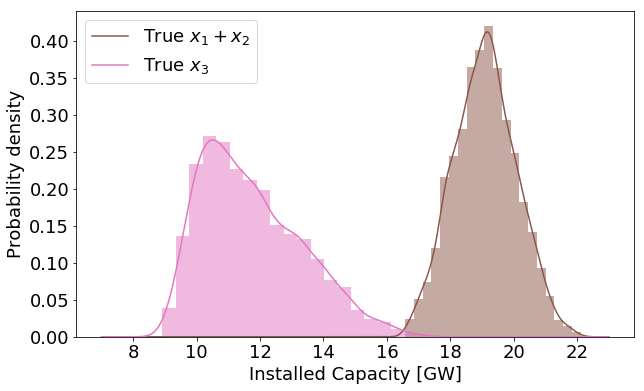

In [99]:
fig, ax = plt.subplots(figsize=(10,6))
ax = plot_hist(ax,interior_points_full[:,0]+interior_points_full[:,1],color='C5')
ax = plot_hist(ax,interior_points_full[:,2],color='C6')
ax.legend(['True $x_1+x_2$','True $x_3$',]);
ax.set_xlabel('Installed Capacity [GW]')
ax.set_ylabel('Probability density')
fig.savefig("C:/Users\Tim\OneDrive - Aarhus universitet\Speciale\Report\Images\multi_7.pdf", bbox_inches='tight')

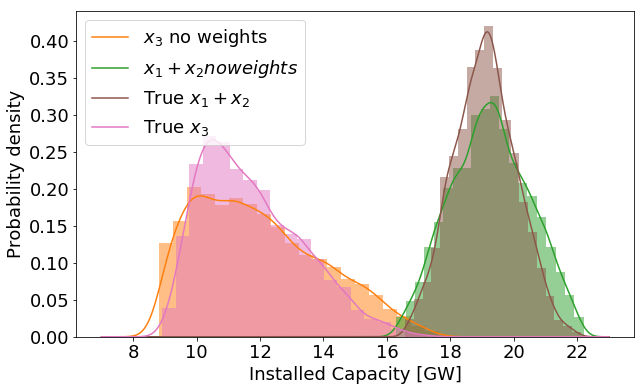

In [100]:
fig, ax = plt.subplots(figsize=(10,6))
ax = plot_hist(ax,interior_points_sum[:,0],color='C1')
ax = plot_hist(ax,interior_points_sum[:,1],color='C2')
ax = plot_hist(ax,interior_points_full[:,0]+interior_points_full[:,1],color='C5')
ax = plot_hist(ax,interior_points_full[:,2],color='C6')
ax.legend(['$x_3$ no weights','$x_1+x_2 no weights$','True $x_1+x_2$','True $x_3$'],loc=2);
ax.set_xlabel('Installed Capacity [GW]')
ax.set_ylabel('Probability density')
fig.savefig("C:/Users\Tim\OneDrive - Aarhus universitet\Speciale\Report\Images\multi_8.pdf", bbox_inches='tight')

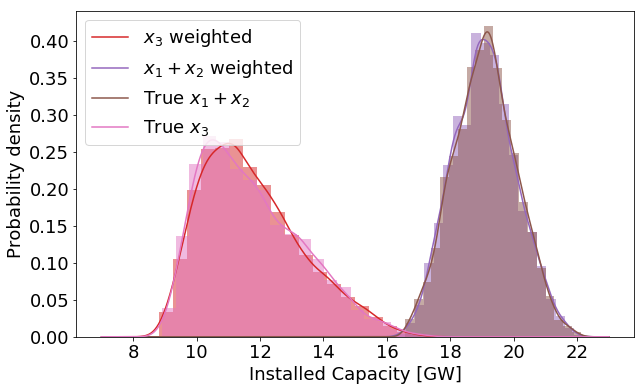

In [101]:
fig, ax = plt.subplots(figsize=(10,6))
#ax = plot_hist(ax,interior_points_sum[:,0],color='C1')
#ax = plot_hist(ax,interior_points_sum[:,1],color='C2')
ax = plot_hist(ax,interior_points_sum[:,0],color='C3',w=interior_weights)
ax = plot_hist(ax,interior_points_sum[:,1],color='C4',w=interior_weights)
ax = plot_hist(ax,interior_points_full[:,0]+interior_points_full[:,1],color='C5')
ax = plot_hist(ax,interior_points_full[:,2],color='C6')
ax.legend(['$x_3$ weighted','$x_1+x_2$ weighted','True $x_1+x_2$','True $x_3$'],loc=2);
ax.set_xlabel('Installed Capacity [GW]')
ax.set_ylabel('Probability density')
fig.savefig("C:/Users\Tim\OneDrive - Aarhus universitet\Speciale\Report\Images\multi_9.pdf", bbox_inches='tight')

### Visualization of problem

In [49]:
n = 3
a1 = sample_points[n,0]
a2 = sample_points[n,1]
print(a1,a2)
s,t = np.meshgrid([1000,20000],[1001,20000])
s = np.reshape(s,[4])
t = np.reshape(t,[4])


12359.314979666047 18561.638435819412


In [50]:
P1 = np.array([0,0.,a1])
A1 = np.array([1,0.,0])
B1 = np.array([0,1,0])

P2 = np.array([a2,0.,0])
A2 = np.array([0,-0.001,1])
B2 = np.array([-1,1,0])

In [51]:
p1 = []
p2 = []
l1 = []
for i in range(len(s)):
    p1.append( P1 +s[i]*A1 + t[i]*B1 )
    p2.append( P2 +s[i]*A2 + t[i]*B2 )
    l1.append( P1 + A1*(P2-P1)/(A1-A2) + t[i]*(A1*(B2-B1)/(A1-A2)+B1) )
p1 = np.array(p1)
p2 = np.array(p2)
l1 = np.array(l1)

In [52]:
fig = go.Figure()

fig.add_trace(go.Scatter3d(x=data_detail_full[:,0],
                          y=data_detail_full[:,1],
                          z=data_detail_full[:,2],
                          mode='markers'))

fig.add_trace(go.Mesh3d(x=p1[:,0],y=p1[:,1],z=p1[:,2],opacity=0.5,color='yellow'))
fig.add_trace(go.Mesh3d(x=p2[:,0],y=p2[:,1],z=p2[:,2],opacity=0.5,delaunayaxis='x',color='yellow'))
fig.add_trace(go.Scatter3d(x=l1[:,0],y=l1[:,1],z=l1[:,2],opacity=1,mode='lines',line=dict(color='red',width=10)))


points = hull_full.points
for s in hull_full.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    fig.add_trace(go.Mesh3d(x=points[s, 0], 
                                y=points[s, 1], 
                                z=points[s, 2],
                                opacity=0.5,
                                color='pink'
                                ))
fig.update_layout(scene = dict(
                     xaxis = dict(nticks=4, range=[0,6000],),
                     yaxis = dict(nticks=4, range=[5000,22500],),
                     zaxis = dict(nticks=4, range=[8500,18000],),),
                 )

fig.show()

In [64]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=data_detail_full[:,0],
                          y=data_detail_full[:,1],
                          #z=data_detail_full[:,2],
                          mode='markers'))



fig.add_trace(go.Scatter(x=l1[:,0],
                         y=l1[:,1],
                         #z=l1[:,2],
                         opacity=1,mode='lines',line=dict(color='red',width=5)))

fig.update_yaxes(title_text='$x_2$',range=[10000,23000])
fig.update_xaxes(title_text='$x_1$',range=[-100,6000])
fig.show()

In [67]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=data_detail_full[:,0],
                          y=data_detail_full[:,2],
                          #z=data_detail_full[:,2],
                          mode='markers'))



fig.add_trace(go.Scatter(x=l1[:,0],
                         y=l1[:,2],
                         #z=l1[:,2],
                         opacity=1,mode='lines',line=dict(color='red',width=5)))

fig.update_yaxes(title_text='$x_3$',range=[7000,20000])
fig.update_xaxes(title_text='$x_1$',range=[-100,6000])
fig.show()